In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# IMPORT PACKAGES

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean.cm
import pandas as pd
import xarray as xr
import collections

AttributeError: module 'dask' has no attribute 'config'

In [3]:
# CODE TO CALCULATE SEASONAL AVERAGE

# Taken from: https://xarray.pydata.org/en/v0.14.0/examples/monthly-means.html
# However test plot in "Seasonal Mean Example" produces somewhat different results-- not sure why.
# usage example: ds_weighted = season_mean(ds,calendar='noleap')

dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
       'julian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

def season_mean(ds, calendar='standard'):

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

In [6]:
# OPEN SAVED OUT DATA
land = {}
land['ctrl'] = xr.open_dataset('PRECIP/land_model.nc').land_mask
land['imerg'] = xr.open_dataset('PRECIP/land_imerg.nc').land_mask
land['cmap'] = xr.open_dataset('PRECIP/land_cmap.nc').land_mask
land['gpcp'] = xr.open_dataset('PRECIP/land_gpcp.nc').land_mask

tsel = {}
tsel['ctrl'] = xr.open_dataset('PRECIP/precip_ctrl.nc').precip
tsel['hitopo'] = xr.open_dataset('PRECIP/precip_hitopo.nc').precip
tsel['cam'] = xr.open_dataset('PRECIP/precip_cam.nc').precip
tsel['imerg'] = xr.open_dataset('PRECIP/precip_imerg.nc').precip
tsel['cmap'] = xr.open_dataset('PRECIP/precip_cmap.nc').precip
tsel['gpcp'] = xr.open_dataset('PRECIP/precip_gpcp.nc').precip

In [21]:
# DATA ANALYSIS

tmean = {}
seasmean = {}

calendars = {'ctrl':'noleap',
             'cam':'noleap',
             'hitopo':'noleap',
             'cmap':'gregorian',
             'gpcp':'gregorian',
             'imerg':'julian'
            }

for key in tsel.keys():
    tmean[key] = tsel[key].mean(dim='time')
    seasmean[key] = season_mean(tsel[key],calendar=calendars[key])

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [22]:
# REGRID AND CALCULATE DIFFERENCE FROM OBS

regrid = collections.defaultdict(dict)
seasmean_regrid = collections.defaultdict(dict)
diff = collections.defaultdict(dict)
seas_diff = collections.defaultdict(dict)
pdiff = collections.defaultdict(dict)
seas_pdiff = collections.defaultdict(dict)
for key in ['imerg','cmap','gpcp']:
    regrid[key] = tmean[key].interp_like(tmean['ctrl'],method='linear')
    seasmean_regrid[key] = seasmean[key].interp_like(tmean['ctrl'],method='linear')
    for run in ['ctrl','hitopo','cam']:
        diff[key][run] = regrid[key] - tmean[run]
        seas_diff[key][run] = seasmean_regrid[key] - seasmean[run]
        pdiff[key][run] = (regrid[key] - tmean[run])/regrid[key]
        seas_pdiff[key][run] = (seasmean_regrid[key] - seasmean[run])/seasmean_regrid[key]

In [26]:
# CALCULATE DIFFERENCE BETWEEN DIFFERENT MODEL RUNS

mdiff = {}
seas_mdiff = {}
for key in ['hitopo','cam']:
    mdiff[key] = tmean['ctrl'] - tmean[key]
    seas_mdiff[key] = seasmean['ctrl'] - seasmean[key]
    

In [73]:
# REGIONS FOR AVERAGING

# Pacific Zonal Limits
xmin = -120+360
xmax = -70+360

# Latitude imits
ymin = 22
ymax = 60
        

TypeError: Cannot label gridlines on a LambertConformal plot.  Only PlateCarree and Mercator plots are currently supported.

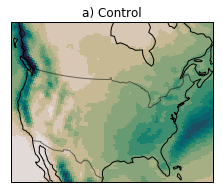

In [109]:
# MAPS COMPARING DIFFERENT MODEL RUNS

fig = plt.figure(figsize=(10,10))

lev = np.arange(0,7.5,0.5)
lev2 = np.arange(-3,3.5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.LambertConformal()

ax1 = plt.subplot(3,2,1,projection=proj)
im1 = tmean['ctrl'].plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.coastlines()
ax1.set_title('a) Control')
ax1.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax1.set_extent([xmin, xmax, ymin, ymax])

ax2 = plt.subplot(3,2,2,projection=proj)
im2 = diff['imerg']['ctrl'].plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.coastlines()
ax2.set_title('b) Obs. - Control')
ax2.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax2.set_extent([xmin, xmax, ymin, ymax])

ax3 = plt.subplot(3,2,3,projection=proj)
tmean['hitopo'].plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.coastlines()
ax3.set_title('c) HiTopo')
ax3.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax3.set_extent([xmin, xmax, ymin, ymax])

ax4 = plt.subplot(3,2,4,projection=proj)
mdiff['hitopo'].plot(ax=ax4, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax4.coastlines()
ax4.set_title('d) HiTopo - Control')
ax4.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax4.set_extent([xmin, xmax, ymin, ymax])

ax5 = plt.subplot(3,2,5,projection=proj)
tmean['cam'].plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax5.coastlines()
ax5.set_title('e) CAm')
ax5.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax5.set_extent([xmin, xmax, ymin, ymax])

ax6 = plt.subplot(3,2,6,projection=proj)
mdiff['cam'].plot(ax=ax6, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax6.coastlines()
ax6.set_title('f) CAm - Control')
ax6.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax6.set_extent([xmin, xmax, ymin, ymax])

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.47, 0.50, 0.02, 0.4])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

cb2_ax = fig.add_axes([0.47, 0.05, 0.02, 0.4])
cb2 = fig.colorbar(im2, cax=cb2_ax)
cb2.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

plt.tight_layout(w_pad = 7)

plt.savefig('us_precip_map.png',dpi = 600)

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


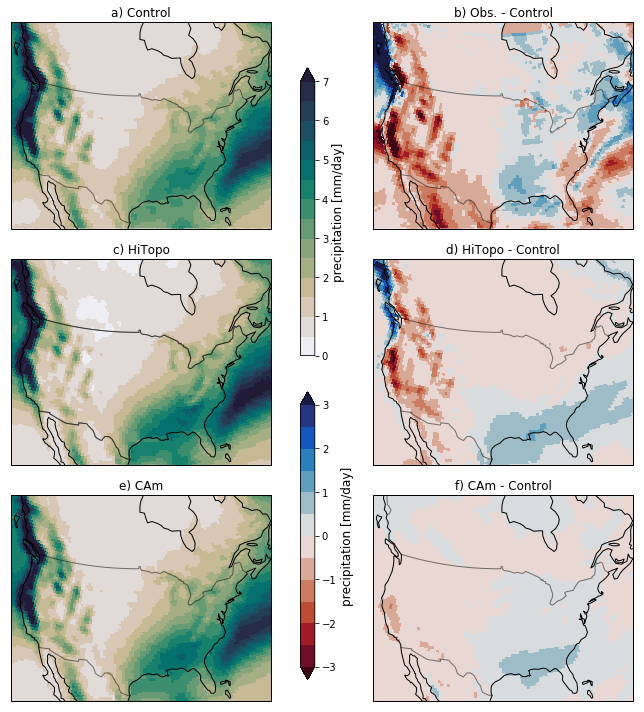

In [106]:
# MAPS COMPARING DIFFERENT MODEL RUNS MAM

fig = plt.figure(figsize=(10,10))

lev = np.arange(0,7.5,0.5)
lev2 = np.arange(-3,3.5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.LambertConformal()

season = 'DJF'

ax1 = plt.subplot(3,2,1,projection=proj)
im1 = seasmean['ctrl'].sel(season=season).plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.coastlines()
ax1.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax1.set_title('a) Control')
ax1.set_extent([xmin, xmax, ymin, ymax])

ax2 = plt.subplot(3,2,2,projection=proj)
im2 = seas_diff['imerg']['ctrl'].sel(season=season).plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.coastlines()
ax2.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax2.set_title('b) Obs. - Control')
ax2.set_extent([xmin, xmax, ymin, ymax])

ax3 = plt.subplot(3,2,3,projection=proj)
seasmean['hitopo'].sel(season=season).plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.coastlines()
ax3.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax3.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax3.set_title('c) HiTopo')
ax3.set_extent([xmin, xmax, ymin, ymax])

ax4 = plt.subplot(3,2,4,projection=proj)
seas_mdiff['hitopo'].sel(season=season).plot(ax=ax4, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax4.coastlines()
ax4.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax4.set_title('d) HiTopo - Control')
ax4.set_extent([xmin, xmax, ymin, ymax])

ax5 = plt.subplot(3,2,5,projection=proj)
seasmean['cam'].sel(season=season).plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax5.coastlines()
ax5.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax5.set_title('e) CAm')
ax5.set_extent([xmin, xmax, ymin, ymax])

ax6 = plt.subplot(3,2,6,projection=proj)
seas_mdiff['cam'].sel(season=season).plot(ax=ax6, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax6.coastlines()
ax6.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax6.set_title('f) CAm - Control')
ax6.set_extent([xmin, xmax, ymin, ymax])

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.47, 0.50, 0.02, 0.4])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

cb2_ax = fig.add_axes([0.47, 0.05, 0.02, 0.4])
cb2 = fig.colorbar(im2, cax=cb2_ax)
cb2.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

plt.tight_layout(w_pad = 7)

plt.savefig('us_precip_map_djf.png',dpi = 600)